# Kaggle RSNA Intracranial Hemorrhage Detection

Ce notebook utilise les données de la compétition [Kaggle RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/overview) pour entraîner un modèle de diffusion stable à générer des images médicales.

## Sommaire

- [0. Importation des bibliothèques](#0-Importation-des-bibliothèques)
- [1. Chargement et prétraitement des données](#1-Chargement-et-prétraitement-des-données)
- [2. Définition du modèle de diffusion](#2-Définition-du-modèle-de-diffusion)
- [3. Entraînement du modèle](#3-Entraînement-du-modèle)
- [4. Génération d'images](#4-Génération-d'images)
- [5. Conclusion](#5-Conclusion)

## 0. Importation des bibliothèques

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # laisse TF n’allouer que ce dont il a besoin

import tensorflow as tf
# (optionnel, équivalent en Python)
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

2025-10-01 17:02:03.472871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import polars as pl
from typing import List
import subprocess
from pathlib import Path

## 1. Chargement et prétraitement des données

Nous allons d'abord charger la liste des identifiants et labels du jeu de données d'entraînement. L'API Kaggle est une option, ou sinon vous pouvez télécharger le fichier CSV manuellement depuis la [page de la compétition](https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/data) et le placer dans le répertoire `../data/rsna-intracranial-hemorrhage-detection`.  

In [3]:
COMPETITION_NAME = "rsna-intracranial-hemorrhage-detection"
DATA_DIRECTORY = "../data/" + COMPETITION_NAME

IMAGE_SIZE = 64  # Taille des images (IMAGE_SIZE x IMAGE_SIZE)
BATCH_SIZE = 8
NUM_CHANNELS = 1  # Nombre de canaux (1 pour grayscale, 3 pour RGB)
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 10

In [4]:
train_dataset_listing = pl.read_csv(f"{DATA_DIRECTORY}/stage_2_train.csv")

In [5]:
train_dataset_listing.head()

ID,Label
str,i64
"""ID_12cadc6af_epidural""",0
"""ID_12cadc6af_intraparenchymal""",0
"""ID_12cadc6af_intraventricular""",0
"""ID_12cadc6af_subarachnoid""",0
"""ID_12cadc6af_subdural""",0


In [6]:
train_dataset_listing['Label'].unique()

Label
i64
0
1


On voit donc que les "ID" sont de la forme "ID_ImageID_HemorrhageType", et que la colonne "Label" ne peut prendre que les valeurs 0 ou 1. Nous allons donc créer une nouvelle colonne "ImageID" qui ne contiendra que la partie "ImageID" de l'ID, et une colonne "HemorrhageType" qui contiendra la partie "HemorrhageType".

In [7]:
lf = pl.scan_csv(f"{DATA_DIRECTORY}/stage_2_train.csv", has_header=True)
lf = lf.with_columns([
    pl.col("ID").str.split(by="_").list.get(2).alias("HemorrhageType"),
    pl.col("ID").str.split(by="_").list.get(1).alias("ImageID"),
])
train_dataset_listing = lf.collect()

In [8]:
train_dataset_listing.head()

ID,Label,HemorrhageType,ImageID
str,i64,str,str
"""ID_12cadc6af_epidural""",0,"""epidural""","""12cadc6af"""
"""ID_12cadc6af_intraparenchymal""",0,"""intraparenchymal""","""12cadc6af"""
"""ID_12cadc6af_intraventricular""",0,"""intraventricular""","""12cadc6af"""
"""ID_12cadc6af_subarachnoid""",0,"""subarachnoid""","""12cadc6af"""
"""ID_12cadc6af_subdural""",0,"""subdural""","""12cadc6af"""


Partant de là, on peut maintenant faire la liste des ImageID uniques :

In [9]:
unique_image_ids = train_dataset_listing['ImageID'].unique()
print(f"Number of unique ImageIDs: {len(unique_image_ids)}")

Number of unique ImageIDs: 752803


Nous allons pouvoir maintenant charger les images DICOM correspondantes à ces ImageID. Pour cela, nous allons créer une fonction qui, pour une liste d'ImageIDs donnée, charge l'image DICOM correspondante, dans un dossier spécifié.

In [10]:
def download_images(image_ids: List[str],
                    destination_directory: str = DATA_DIRECTORY):
    """
    Download DICOM files from Kaggle CLI.

    Parameters
    ----------
    image_ids : List[str]
        List of DICOM IDs to download (without extension)
    destination_directory : str
        Path to the directory where to save the downloaded files
    """
    Path(destination_directory).mkdir(parents=True, exist_ok=True)

    for iid in image_ids:
        remote_path = f"rsna-intracranial-hemorrhage-detection/stage_2_train/ID_{iid}.dcm"
        subprocess.run(
            [
                "kaggle", "competitions", "download",
                "-c", COMPETITION_NAME,
                "-f", remote_path,
                "-p", destination_directory
            ],
            check=True
        )

Testons cette fonction en téléchargeant les images correspondant aux 5 premiers ImageIDs uniques :

In [11]:
first_5_image_ids = unique_image_ids[:5]
download_images(first_5_image_ids)

100%|██████████| 513k/513k [00:00<00:00, 1.34GB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.46GB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.37GB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.74GB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.19GB/s]


### Visualisation des images

Maintenant que nous avons les images, nous allons les visualiser pour vérifier que tout est correct. Commençons par les lister :

In [12]:
def list_downloaded_images(destination_directory: str = DATA_DIRECTORY) -> List[Path]:
    """
    List all downloaded DICOM files in the destination directory.

    Parameters
    ----------
    destination_directory : str
        Path to the directory where the files are saved

    Returns
    -------
    List[Path]
        List of paths to the downloaded DICOM files
    """
    return list(Path(destination_directory).glob("ID_*.dcm"))

In [13]:
list_downloaded_images()

[PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_e4ebe402e.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_be54460bf.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_ca9182e6a.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_bffeea9e1.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_a8e7dfde8.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_6c2286816.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_a67e7dc79.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_5e4290d80.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_2267527bd.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_a3d91629a.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_f1a7d5dfe.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_08ec2f729.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-det

Nous pouvons maintenant visualiser les images téléchargées. Pour cela, nous allons utiliser la bibliothèque `pydicom` pour lire les fichiers DICOM et `matplotlib` pour afficher les images. Nous allons également appliquer une fenêtre de visualisation pour améliorer le contraste de l'image. La fonction `_resolve_window` permet de déterminer les paramètres de la fenêtre en fonction du type d'image (par exemple, "brain", "bone", etc.).

In [14]:
from typing import Sequence, Tuple, Union, Dict
from pathlib import Path
import math
import numpy as np
import pydicom
import matplotlib.pyplot as plt

WindowSpec = Union[str, Tuple[float, float], None]

_PRESETS: Dict[str, Tuple[float, float]] = {
    "brain": (40.0, 80.0),
    "subdural": (70.0, 200.0),
    "bone": (600.0, 3000.0),
}

def _to_hu(ds: pydicom.dataset.FileDataset) -> np.ndarray:
    """Convert stored pixels to Hounsfield Units (HU)."""
    arr = ds.pixel_array.astype(np.float32, copy=False)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    return arr * slope + intercept

def _resolve_window(
    ds: pydicom.dataset.FileDataset,
    window: WindowSpec
) -> Tuple[float, float]:
    """Return (center, width) from preset/tuple or DICOM tags, else full range."""
    if isinstance(window, str):
        c, w = _PRESETS[window.lower()]
        return float(c), float(w)
    if isinstance(window, tuple):
        c, w = window
        return float(c), float(w)

    # Fallback: use DICOM WindowCenter/WindowWidth if present (first pair)
    wc = getattr(ds, "WindowCenter", None)
    ww = getattr(ds, "WindowWidth", None)
    if wc is not None and ww is not None:
        # tags peuvent être MultiValue
        if hasattr(wc, "__iter__"):
            wc = wc[0]
        if hasattr(ww, "__iter__"):
            ww = ww[0]
        return float(wc), float(ww)

    # Last resort: cover the data range
    hu = _to_hu(ds)
    return float(np.nanmin(hu)), float(np.nanmax(hu))

def visualize_images(
    image_ids: Sequence[str],
    nrows: int = 1,
    dicom_files_location: str = DATA_DIRECTORY,
    figsize_per_panel: float = 3.0,
    window: WindowSpec = "brain",
) -> None:
    """Display multiple DICOM images with CT windowing.

    Parameters
    ----------
    image_ids : sequence of str
        IDs sans extension (ex: '6f383268c').
    nrows : int
        Nombre de lignes du grid.
    dicom_files_location : str
        Répertoire des DICOM.
    figsize_per_panel : float
        Taille (en pouces) par vignette.
    window : {"brain","bone","subdural"} or (center,width) or None
        Fenêtrage à appliquer. None => utilise les tags DICOM s'ils existent.
    """
    n = len(image_ids)
    if n == 0 or nrows <= 0:
        return
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * figsize_per_panel, nrows * figsize_per_panel),
    )
    flat_axes = np.atleast_1d(axes).ravel()

    for ax, img_id in zip(flat_axes, image_ids):
        ds = pydicom.dcmread(Path(dicom_files_location) / f"ID_{img_id}.dcm")
        hu = _to_hu(ds)

        center, width = _resolve_window(ds, window)
        if width > 0 and center != np.nan:
            vmin = center - width / 2.0
            vmax = center + width / 2.0
            ax.imshow(hu, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        else:
            ax.imshow(hu, cmap=plt.cm.gray)

        ax.set_title(f"Image ID: {img_id}")
        ax.axis("off")

    for ax in flat_axes[n:]:
        ax.remove()

    plt.tight_layout()
    plt.show()


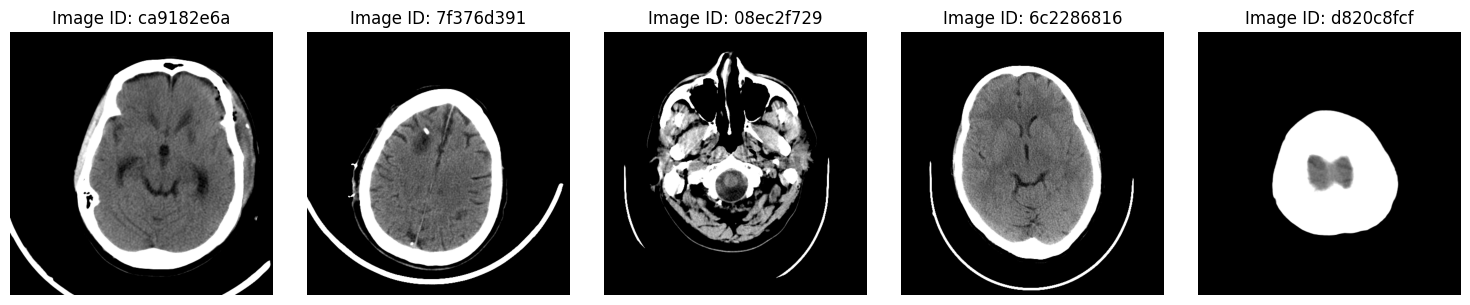

In [15]:
visualize_images(first_5_image_ids, window="brain")

### Conversion des images en tableaux numpy, et création d'un dataset tensorflow

Nous allons maintenant convertir les images DICOM en tableaux numpy, et créer un dataset TensorFlow à partir de ces tableaux.

In [16]:
# Charge tous les DICOM, window "brain", normalise [0,1], => tf.data.Dataset
from pathlib import Path
import numpy as np
import pydicom
import tensorflow as tf

WL, WW = 40.0, 80.0  # brain: level=40, width=80

def _load_norm(p: Path) -> np.ndarray:
    ds = pydicom.dcmread(str(p))
    hu = ds.pixel_array.astype(np.float32) * float(getattr(ds, "RescaleSlope", 1.0)) + float(getattr(ds, "RescaleIntercept", 0.0))
    vmin, vmax = WL - WW/2.0, WL + WW/2.0
    return np.clip((hu - vmin) / WW, 0.0, 1.0)  # (H,W) in [0,1]

paths = sorted(Path(DATA_DIRECTORY).glob("ID_*.dcm"))
images = np.stack([_load_norm(p) for p in paths], dtype=np.float32)[..., None]  # (N,H,W,1)

tf_dataset = tf.data.Dataset.from_tensor_slices(images)

print("Nombre d'images :", len(tf_dataset))
print("Dimension des tenseurs dans le dataset :", tf_dataset.element_spec)


Nombre d'images : 45
Dimension des tenseurs dans le dataset : TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None)


I0000 00:00:1759330935.823042 3339749 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1744 MB memory:  -> device: 0, name: Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5


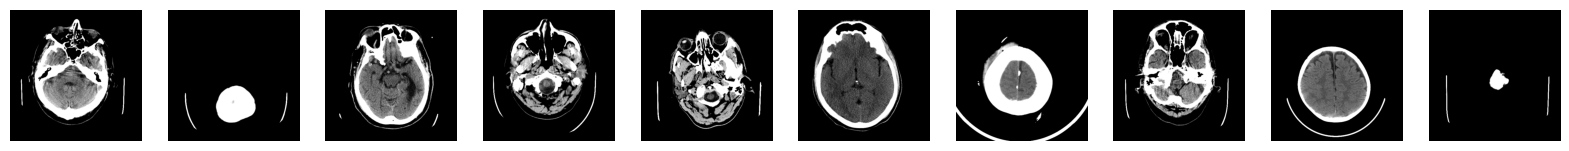

In [17]:
from utils import display, sample_batch

train_sample = sample_batch(tf_dataset.batch(10))  # batch éphémère
display(train_sample, n=10, cmap="gray")

## Entraînement du modèle de diffusion

Nous allons reprendre les classes et fonctions du tutoriel de David Foster, puis les adapter pour notre dataset.

In [18]:
from diffusion_models import DiffusionModel

diffusion_model = DiffusionModel(
    image_size=IMAGE_SIZE,
    num_channels=NUM_CHANNELS,
    noise_embedding_size=NOISE_EMBEDDING_SIZE,
    batch_size=BATCH_SIZE,
    ema=EMA
)

In [19]:
x = next(iter(tf_dataset))
print("Input shape:", x.shape)

Input shape: (512, 512, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Active le calcul en 16 bits (moins de mémoire)
mixed_precision.set_global_policy("mixed_float16")

# Adapte le dataset aux tailles et batch
train_dataset = tf_dataset.map(
    lambda x: tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE]),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [21]:
x = next(iter(train_dataset))
print("Input shape:", x.shape)

Input shape: (64, 64, 1)


Epoch 1/10


2025-10-01 17:02:18.614471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-01 17:02:28.127369: I external/local_xla/xla/service/service.cc:163] XLA service 0x757798053230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-01 17:02:28.127384: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro T1000, Compute Capability 7.5
2025-10-01 17:02:28.425067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-01 17:02:28.908754: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:62] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-10-01 17:02:29.938485: I external/local_xla/xla/s

 3/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - n_loss: 1.0026

I0000 00:00:1759330984.196240 3340238 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.9728
Saved to ./output/generated_img_000.png


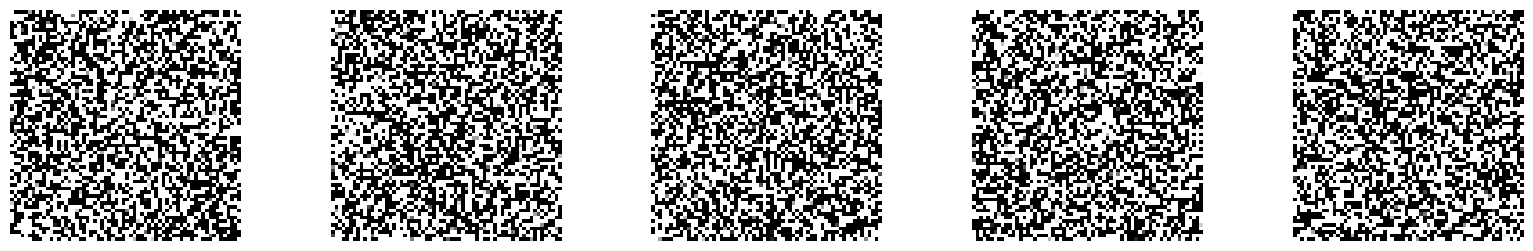

45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - n_loss: 0.9191
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.5582
Saved to ./output/generated_img_001.png


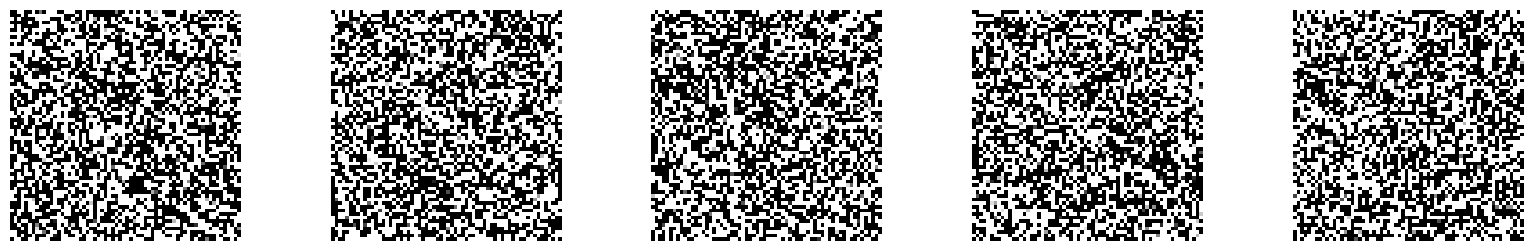

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - n_loss: 0.4167
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1968
Saved to ./output/generated_img_002.png


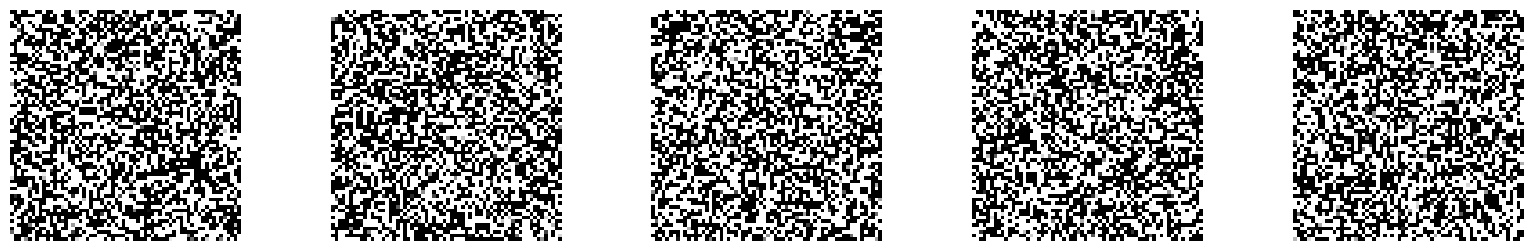

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - n_loss: 0.1821
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1542
Saved to ./output/generated_img_003.png


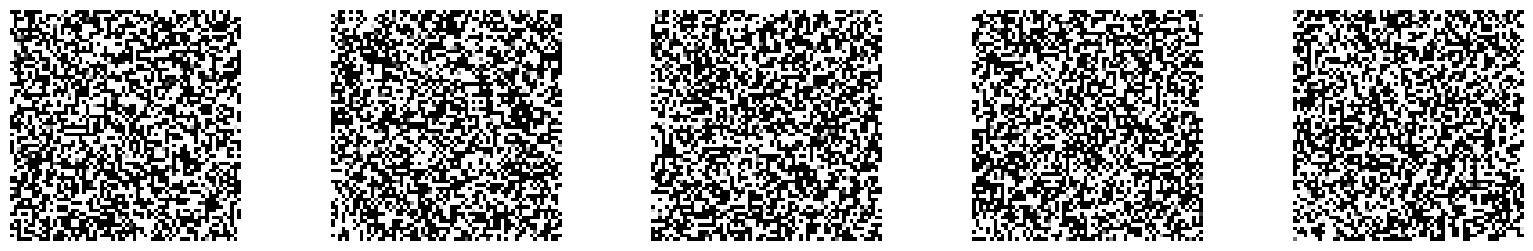

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - n_loss: 0.1557
Epoch 5/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1577
Saved to ./output/generated_img_004.png


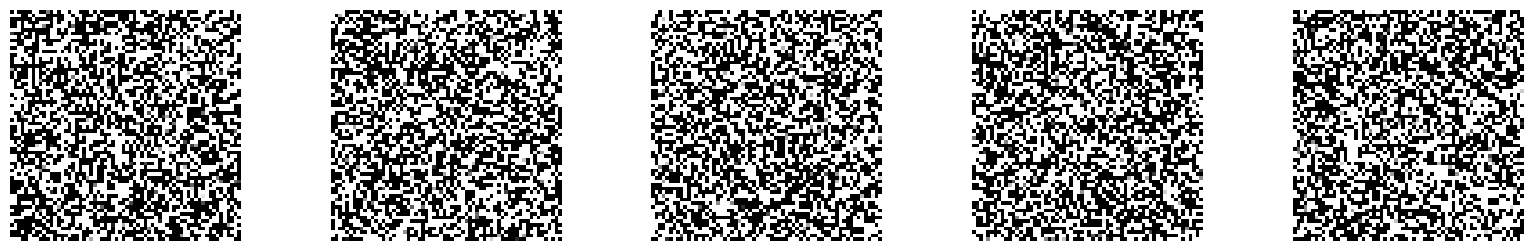

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - n_loss: 0.1515
Epoch 6/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1403
Saved to ./output/generated_img_005.png


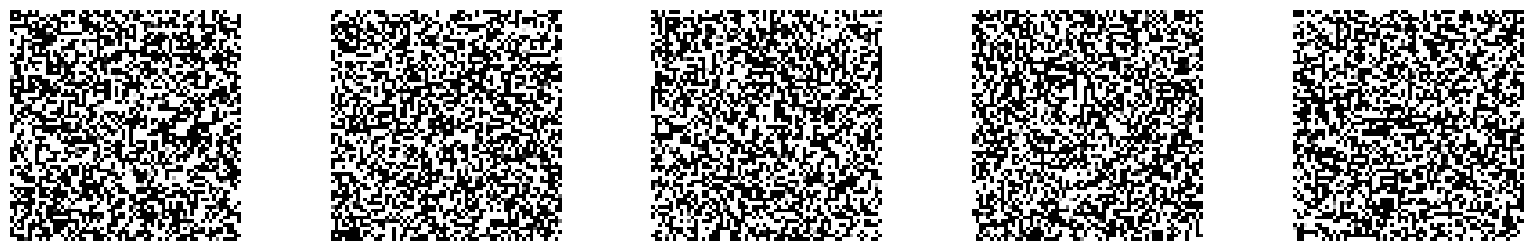

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - n_loss: 0.1396
Epoch 7/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1331
Saved to ./output/generated_img_006.png


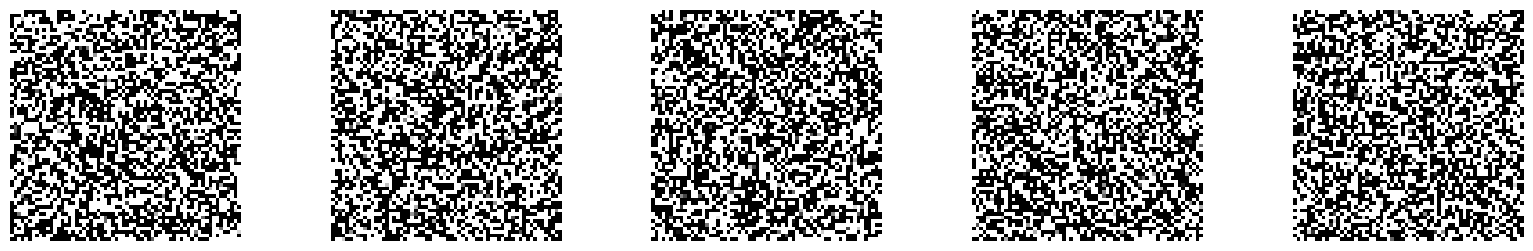

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - n_loss: 0.1257
Epoch 8/10
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - n_loss: 0.1318

KeyboardInterrupt: 

In [22]:
history = diffusion_model.train(train_dataset, epochs=EPOCHS)